In [1]:
from src.Library import *
from Data_Preparation import *
#from Data_Preparation2 import *
import folium
import pickle
from icecream import ic
from sklearn.mixture import GaussianMixture
from catboost import CatBoostClassifier
from datetime import datetime, time
import shutil
from IPython.display import Markdown, display


def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [2]:
def speed_estimation(trip_record):
    """
    Estimate the speed with the GPS points and calculate some statistical measures of the estimation.
    :param trip_record: data frame with the original GPS meta-data
    :return: trip_record data frame with new columns - prev_time, prev_latitude, prev_longitude
    """
    trip_record['prev_time'] = trip_record['orig_time'].shift(1)
    trip_record['prev_latitude'] = trip_record['latitude'].shift(1)
    trip_record['prev_longitude'] = trip_record['longitude'].shift(1)
    trip_record['speed_est'] = trip_record.apply(lambda row: haversine(row['prev_longitude'], row['prev_latitude'],
                                                                       row['longitude'], row['latitude']) /
                                                             ((row['orig_time']-row['prev_time']).seconds/(60*60)),
                                                 axis=1)
#     pearson_corr, p_value = pearsonr(trip_record['speed_est'].iloc[1:], trip_record['speed'].iloc[1:])
#     plt.plot(trip_record['orig_time'], trip_record['speed_est'])
#     plt.plot(trip_record['orig_time'], trip_record['speed'])
#     plt.show()
    return trip_record


def acceleration_estimation(trip_record):
    """
    Estimate the acceleration with the speed data.
    :param trip_record: data frame with the original GPS meta-data
    :return: trip_record data frame with new columns - prev_time, next_time, prev_speed, next_speed,
                acceleration_est_1/2/3
    """
    trip_record['prev_time'] = trip_record['orig_time'].shift(1)
    trip_record['next_time'] = trip_record['orig_time'].shift(-1)
    trip_record['prev_speed'] = trip_record['speed'].shift(1)
    trip_record['next_speed'] = trip_record['speed'].shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    trip_record['acceleration_est_1'] = trip_record.apply(lambda row: (row['next_speed'] - row['prev_speed']) /
                                                                      (row['next_time'] - row['prev_time']).seconds
                                                          , axis=1)
    trip_record.at[trip_record.index[0], 'acceleration_est_1'] = (trip_record['next_speed'].iloc[0] -
                                                                  trip_record['speed'].iloc[0]) / \
                                                                 (trip_record['next_time'].iloc[0] -
                                                                  trip_record['orig_time'].iloc[0]).seconds
    trip_record.at[trip_record.index[-1], 'acceleration_est_1'] = (trip_record['speed'].iloc[-1] -
                                                                   trip_record['prev_speed'].iloc[-1]) / \
                                                                  (trip_record['orig_time'].iloc[-1]
                                                                   - trip_record['prev_time'].iloc[-1]).seconds
    """trip_record['acceleration_est_2'] = trip_record.apply(lambda row: (row['speed'] - row['prev_speed']) /
                                                                      (row['orig_time'] - row['prev_time']).seconds,
                                                          axis=1)
    trip_record['acceleration_est_3'] = trip_record.apply(lambda row: (row['next_speed'] - row['speed']) /
                                                                      (row['next_time'] - row['orig_time']).seconds
                                                          , axis=1)"""
    return trip_record


def angular_acc_estimation(trip_record):
    """
    create the angular acc estimation
    :param trip_record: data frame having the shifted columns from the acceleration estimation function.
    :return: 3 new columns to the trip data frame - prev direction, next direction, and angular acc.
    """
    # trip_no_idle = trip_record.copy()
    trip_record = trip_record.copy().loc[~((trip_record['orig_time'] == trip_record['prev_time']) |
                                           (trip_record['orig_time'] == trip_record['next_time']))]
    trip_record['prev_direction'] = trip_record.direction.shift(1)
    trip_record['next_direction'] = trip_record.direction.shift(-1)
    # trip_record['prev_time'] = trip_record.orig_time.shift(1)
    # trip_record['next_time'] = trip_record.orig_time.shift(-1)
    trip_record = trip_record.copy().loc[~(trip_record['next_time'] == trip_record['prev_time'])]
    trip_record['angular_acc'] = trip_record.apply(lambda row:
                                                   (row['next_direction'] - 2 * row['direction'] + row['prev_direction']) /
                                                   ((row['next_time'] - row['orig_time']).seconds * (row['orig_time'] - row['prev_time']).seconds), axis=1)
    return trip_record

In [3]:
def trip_on_map(df):
    # Create a map object
    m = folium.Map(location=[0, 0], zoom_start=2)

    # Define colors for markers
    colors = {2: 'green', 0: 'blue', 1: 'red', 3: 'orange', 4: 'pink', 5: 'teal', 6: 'maroon', 7: 'lavender'}

    color = colors[0]
    j = 0 


    for i, row in df.iterrows():
        if row['speed'] == 0:
            color = colors[1]
            rad = 8
        else:
            color = colors[0]
            rad = 5
        lat, lon = row['latitude'], row['longitude']
        folium.CircleMarker(location=[lat, lon], radius=rad, color=color, fill=True, fill_color=color).add_to(m)

    # Display the map
    return m


In [4]:
def get_neighborhood_name(latitude, longitude):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if 'address' in data:
            if 'neighbourhood' in data['address']:
                return data['address']['neighbourhood']
            elif 'suburb' in data['address']:
                return data['address']['suburb']
            elif 'town' in data['address']:
                return data['address']['town']
            elif 'city' in data['address']:
                return data['address']['city']
            else:
                return "Neighborhood not found"
        else:
            return "Neighborhood not found"
    
    except Exception as e:
        return f"Error: {e}"

In [5]:
def translate_hebrew_to_english(text):
    url = f"https://api.mymemory.translated.net/get?q={text}&langpair=he|en"
    response = requests.get(url)
    data = response.json()
    
    if 'responseData' in data:
        return data['responseData']['translatedText']
    else:
        return "Translation not available"

# Example usage:
hebrew_text = "שלום, זהו דוגמה לטקסט בעברית."
english_translation = translate_hebrew_to_english(hebrew_text)
print("English Translation:", english_translation)

English Translation: Hi, This is an example of Hebrew text.


In [6]:


def get_data_of_cor(latitude, longitude):
    url = f"https://nominatim.openstreetmap.org/reverse?format=json&lat={latitude}&lon={longitude}"
    
    try:
        response = requests.get(url)
        data = response.json()
#         pprint(data)
    except:
        None
    return data

In [20]:
get_data_of_cor(32.165485,34.857773)['address']['town']

NameError: name 'get_data_of_cor' is not defined

In [4]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = concated_data_with_feat(460631)

In [ ]:
df.index = df.drive_id

In [ ]:
df = df[['start_latitude','start_longitude','end_latitude','end_longitude']]

In [ ]:
import reverse_geocoder as rg
rg.search((32.136062, 34.798051))[0]['name']

In [ ]:
cities_df = df.groupby(['start_city', 'end_city']).count().sort_values('start_latitude', ascending=False)
cities_df = cities_df[cities_df['start_latitude']>10]

In [ ]:
cities_lst = []
for i, row in cities_df.iterrows():
    cities_lst.append(i)


In [ ]:
df

In [ ]:
# Function to get city from location data
def get_city_from_location(location_data):
    if 'town' in location_data['address']:
        return location_data['address']['town']
    elif 'city' in location_data['address']:
        return location_data['address']['city']
    elif 'municipality' in location_data['address']:
        return location_data['address']['municipality']
    else:
        return 'None'

In [ ]:
def process_drive_row(row):
    start_data = get_data_of_cor(row['start_latitude'], row['start_longitude'])
    end_data = get_data_of_cor(row['end_latitude'], row['end_longitude'])

    start_city = get_city_from_location(start_data)
    end_city = get_city_from_location(end_data)

    # Set start_city and end_city individually
    df_drives.at[row.name, 'start_city'] = start_city
    df_drives.at[row.name, 'end_city'] = end_city

In [5]:
all_trips = []
for year in ['2018','2019']:
        for month in range(1,13,1): 

            with open(f"/bigdata/users-home/dor/transpotation research/agg_data/preprocessGlobalFeatures/{str(month)}_{year}_[460631]_trips.pickle", 'rb') as handle:
                    trips_lst = pickle.load(handle)
            for trip in trips_lst[0]:
                
#                 trip.time_series_record.drop_duplicates(subset=['orig_time'], keep=False)
#                 curr_trip = speed_estimation(trip.time_series_record)
                curr_trip = acceleration_estimation(trip.time_series_record)
                curr_trip =angular_acc_estimation(curr_trip)
                curr_trip = curr_trip[(curr_trip['vehicle_state'] == 1) | (curr_trip['vehicle_state'] == 2)]
                curr_trip['date'] = curr_trip['orig_time'].dt.date
                curr_trip['hour'] = curr_trip['orig_time'].dt.time
                curr_trip['drive_id'] = trip.id
                
                curr_trip.drop(['prev_time',
                       'next_time','prev_speed','next_speed','prev_direction',
                      'next_direction','mileage','vehicle_id'],axis=1,inplace=True)
                all_trips.append(curr_trip)
print(len(all_trips))

2711


In [6]:
all_trips[0]

,longitude,latitude,orig_time,speed,direction,vehicle_state,road_speed,acceleration_est_1,angular_acc,date,hour,drive_id
0,34.857773,32.165485,2018-01-05 06:01:49,0,0,2,50.0,0.0,NaN,2018-01-05,06:01:49,12808103918
1,34.857773,32.165488,2018-01-05 06:01:53,0,0,2,50.0,0.0,0.0,2018-01-05,06:01:53,12808103918
2,34.857770,32.165486,2018-01-05 06:01:57,0,0,2,50.0,0.0,0.0,2018-01-05,06:01:57,12808103918
3,34.857770,32.165493,2018-01-05 06:02:01,0,0,2,50.0,0.0,0.0,2018-01-05,06:02:01,12808103918
4,34.857771,32.165495,2018-01-05 06:02:05,0,0,2,50.0,0.0,0.0,2018-01-05,06:02:05,12808103918
...,...,...,...,...,...,...,...,...,...,...,...,...
130,34.818151,32.112946,2018-01-05 06:22:46,7,0,1,NaN,0.0,0.0,2018-01-05,06:22:46,12808103918
131,34.818151,32.112946,2018-01-05 06:22:56,7,0,1,NaN,0.0,0.0,2018-01-05,06:22:56,12808103918
132,34.818151,32.112946,2018-01-05 06:22:59,7,0,1,NaN,0.0,0.0,2018-01-05,06:22:59,12808103918
133,34.818151,32.112946,2018-01-05 06:23:08,7,0,1,NaN,0.0,0.0,2018-01-05,06:23:08,12808103918


In [7]:


def get_road_coordinates(road_name):
    url = f"https://nominatim.openstreetmap.org/search?format=json&q={road_name}"
    try:
        response = requests.get(url)
        data = response.json()
#         pprint(data)
        coordinates = [item['boundingbox'] for item in data if item['addresstype']=='road']
    except:
        coordinates = []
    return coordinates


In [9]:

# get_road_coordinates(get_data_of_cor(32.160545, 34.820520)['address']['road'])

the amount of filtered drives: 2220
71


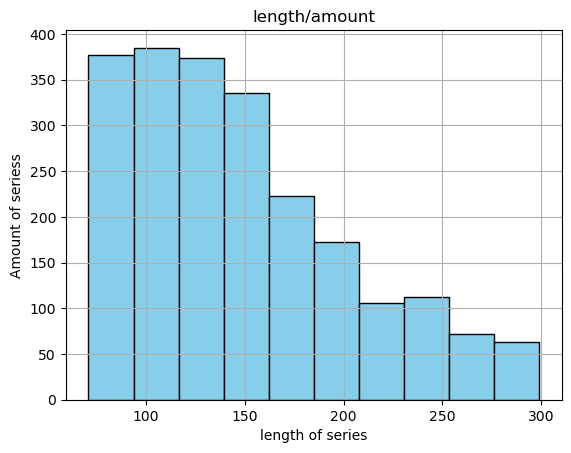

In [8]:
import matplotlib.pyplot as plt
min_df = 0
minimum = 180
lengths = []
filtered_trips = [series for series in all_trips if (len(series) > 70 and len(series) < 300)  and (np.max(series.speed)>0 or np.max(series.vehicle_state)<2)]
print('the amount of filtered drives:',len(filtered_trips))
for series in filtered_trips:
    len_cur = len(series)
    lengths.append(len_cur)
    if len_cur < minimum:
        minimum = len_cur
        min_df = series
print(minimum)
plt.hist(lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('length of series')
plt.ylabel('Amount of seriess')
plt.title('length/amount')
plt.grid(True)
plt.show()



In [11]:
trip_on_map(min_df)

In [12]:
file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_drives.pickle"

# Read the pickle file
with open(file_path, 'rb') as handle:
    dict_drives = pickle.load(handle)

# Now you can use the dictionary stored in dict_drives
# For example, print the keys of the dictionary
print(dict_drives.keys())

dict_keys([1, 2, 3, 5, 6, 4])


In [13]:
drives_lst = [list(dict_drives[group].index) for group in dict_drives]


In [14]:
ts_drives = []
for trip in filtered_trips:
    for ind in drives_lst:
        if np.mean(trip.drive_id) in ind:
#             new_index = pd.date_range(start, end, freq='0.5min')
            ts_drives.append(trip)
print(len(ts_drives))

754


71


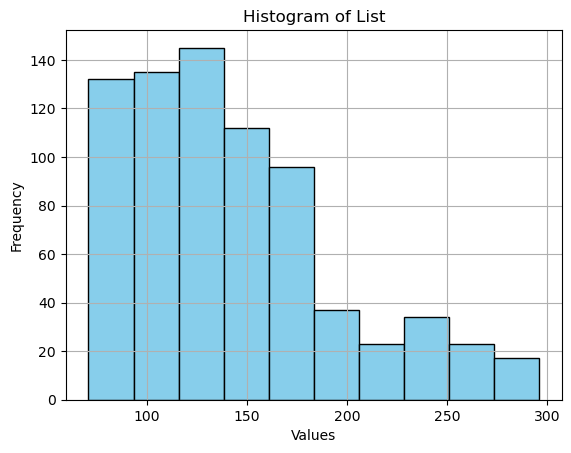

In [15]:
minimum =1000
min_df = 0
lengths =[]
for series in ts_drives:
    len_cur = len(series)
    lengths.append(len_cur)
    if len_cur < minimum:
        minimum = len_cur
        min_df = series
print(minimum)
plt.hist(lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of List')
plt.grid(True)
plt.show()

In [16]:
groups_ts = {}

for group in dict_drives:
    for ind , row in dict_drives[group].iterrows():
        for series in ts_drives:
            if np.mean(series.drive_id) == ind:
                groups_ts[group] = groups_ts.get(group , [])
                groups_ts[group].append(series)
                break


In [17]:

def split_dataframe(df):
    lst = []
    df_indices = []
    for i, row in df.iterrows():
        try:
            if row.speed == 0 and df.loc[i + 1].speed != 0:
                lst.append(df_indices)
                df_indices = []
        except KeyError:
            pass
        df_indices.append(i)
    lst.append(df_indices)  # Append the last set of indices

    dataframes = [df[df.index.isin(indices)] for indices in lst if indices]  # Exclude empty lists

    return dataframes



In [18]:
splitted_ts_drives = []
for trip in ts_drives:
    sub_trips_lst = split_dataframe(trip)
    for sub_trip in sub_trips_lst:
        splitted_ts_drives.append(sub_trip)


In [19]:
import numpy as np
start_coor = set()

new_splitted_ts_drives = []
for series in splitted_ts_drives:
    if np.max(series.speed) != 0:
        series = series.drop_duplicates(subset=['longitude', 'latitude'])
        new_splitted_ts_drives.append(series)
        
splitted_ts_drives = new_splitted_ts_drives


In [20]:
trip_coors = set()

for series in splitted_ts_drives:
    first_row_coords = series.iloc[0][['longitude', 'latitude']].tolist()
    last_row_coords = series.iloc[-1][['longitude', 'latitude']].tolist()

  
    
    # Round each coordinate number
    first_row_coords_rounded = [round(coord, 5) for coord in first_row_coords]
    last_row_coords_rounded = [round(coord, 5) for coord in last_row_coords]
  

    # Add rounded coordinates to the set individually
    trip_coors.add(tuple(first_row_coords_rounded))
    trip_coors.add(tuple(last_row_coords_rounded))

In [21]:
trip_coors

{(34.81803, 32.1129),
 (34.80152, 32.11859),
 (34.83806, 32.16186),
 (34.81688, 32.11094),
 (34.86107, 32.16504),
 (34.84722, 32.1624),
 (34.81808, 32.11781),
 (34.81676, 32.11347),
 (34.80977, 32.11968),
 (34.84219, 32.15822),
 (34.80452, 32.12098),
 (34.85286, 32.16935),
 (34.81798, 32.11289),
 (34.85724, 32.16485),
 (34.80958, 32.14192),
 (34.80984, 32.12002),
 (34.85217, 32.1785),
 (34.83613, 32.16226),
 (34.82988, 32.16317),
 (34.84228, 32.16097),
 (34.79452, 32.15831),
 (34.85338, 32.16257),
 (34.8249, 32.16365),
 (34.79512, 32.15829),
 (34.88922, 32.17393),
 (34.83358, 32.13353),
 (34.83718, 32.14256),
 (34.8393, 32.16161),
 (34.79486, 32.15791),
 (34.84608, 32.18782),
 (34.85777, 32.16537),
 (34.81759, 32.11105),
 (34.80179, 32.11576),
 (34.82782, 32.16346),
 (34.81805, 32.11788),
 (34.80678, 32.10987),
 (34.80982, 32.11963),
 (34.80143, 32.11319),
 (34.84224, 32.16087),
 (34.82372, 32.16401),
 (34.81896, 32.16153),
 (34.84376, 32.16051),
 (34.85772, 32.16536),
 (34.83973, 32.1

In [22]:
def get_nearest_road(lat, lon):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    way(around:50,{lat},{lon})["highway"];
    (._;>;);
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    for element in data['elements']:
        if 'tags' in element and 'name' in element['tags']:
            return element['tags']['name']
    return "No road found within 50 meters."

In [23]:
def split_list(lst, n):
    return [lst[i::n] for i in range(n)]

In [24]:


def Prepare_coors_metadata_by_road_names(directory_d='/data/inputs/Year_Data/DRIVES', directory_g='/data/inputs/Year_Data/GPS', allowed_road_names=[]):
    """
    Export data based on coordinates and date.

    Args:
        directory_d (str): The directory for drive data (default is '/data/inputs/Year_Data/DRIVES').
        directory_g (str): The directory for GPS data (default is '/data/inputs/Year_Data/GPS').
        allowed_road_names (list): A list of road names to filter the data.

    Returns:
        None
    """
    start_time = time.time() 
    finishes = False
    for year in ['2018','2019']:
        if finishes:
            break
        for month in range(1,13,1): 
            if finishes:
                break
            
            else:
                if len(str(month))==1:
                    # Create the path for the year and month
                    year_path_d = os.path.join(directory_d, str(year))
                    month_path_d = os.path.join(year_path_d, '0'+str(month))
                    year_path_g = os.path.join(directory_g, str(year))
                    month_path_g = os.path.join(year_path_g, '0'+str(month))
                else:
                    year_path_d = os.path.join(directory_d, str(year))
                    month_path_d = os.path.join(year_path_d, str(month))
                    year_path_g = os.path.join(directory_g, str(year))
                    month_path_g = os.path.join(year_path_g, str(month))

                # List all the day folders
                days = os.listdir(month_path_d)
                final_df_dict = {}
                # List to store the DataFrames
                dfs_d = []
                dfs_g = []
                coor_fixed = []
                splitted_days = split_list(days, 5)
                
                for days_batch in splitted_days:
                    if os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{month}_{year}__{days_batch}.pickle"):
                        continue
                    else:
                        for day in days_batch:
                            curr_time = time.strftime('%H:%M:%S', time.localtime(time.time()))
                            print(f'processing {day} out of days in {month}/{year}/{days_batch} started:{curr_time}')
                            if time.time() - start_time >= 20 * 60 * 60:
                                finishes = True
                                break
                            try:
                                day_path_d = os.path.join(month_path_d, day)
                                day_path_g = os.path.join(month_path_g, day)

                                # List all the CSV files in the day folder
                                try:
                                    csv_files_d = [f for f in os.listdir(day_path_d) if f.endswith('.csv.gz')][0]
                                    csv_files_d = os.path.join(day_path_d, csv_files_d)
                                    df_drives = pd.read_csv(csv_files_d)
                                except:
                                    lst = []
                                    csv_files_d = [f for f in os.listdir(day_path_d)]

                                    # Iterate over CSV files
                                    for path in csv_files_d:
                                        csv_dd = os.path.join(day_path_d, path)
                                        csv_d = [f for f in os.listdir(csv_dd) if f.endswith('.csv.gz')][0]
                                        csv_dd = os.path.join(csv_dd, csv_d)
                                        lst.append(pd.read_csv(csv_dd))
                                    df_drives = pd.concat(lst, ignore_index=True)

                                try:
                                    csv_files_g = [f for f in os.listdir(day_path_g) if f.endswith('.csv.gz')][0]
                                    csv_files_g = os.path.join(day_path_g, csv_files_g)
                                    df_gps = pd.read_csv(csv_files_g)
                                except:
                                    lst = []
                                    csv_files_g = [f for f in os.listdir(day_path_g)]

                                    # Iterate over CSV files
                                    for path in csv_files_g:
                                        csv_gg = os.path.join(day_path_g, path)
                                        csv_g = [f for f in os.listdir(csv_gg) if f.endswith('.csv.gz')][0]
                                        csv_gg = os.path.join(csv_gg, csv_g)
                                        lst.append(pd.read_csv(csv_gg))
                                    df_gps = pd.concat(lst, ignore_index=True)
                            except:
                                continue

                            df_gps.columns = df_gps.columns.str.lower()

                            df_gps['orig_time'] = pd.to_datetime(df_gps['orig_time'])

                            df_gps = df_gps.sort_values(by=['vehicle_id', 'orig_time']) 
                            coor_dict = {}
                            df_indices = []


                            # Iterate over DataFrame rows with tqdm for progress indication
                            for i, row in tqdm(df_gps.iterrows(), total=len(df_gps), desc="Processing rows"):
                                try:
                                    if row.speed == 0 and df_gps.loc[i + 1].speed != 0:
                                        curr = df_gps[df_gps.index.isin(df_indices)]
                                        curr_tuple = (
                                            (
                                                round(float(curr.iloc[0]["longitude"]), 5),
                                                round(float(curr.iloc[0]["latitude"]), 5),
                                            ),
                                            (
                                                round(float(curr.iloc[-1]["longitude"]), 5),
                                                round(float(curr.iloc[-1]["latitude"]), 5),
                                            ),
                                        )
                                        coor_dict[round(curr_tuple[0][0]*10,0)] = coor_dict.get(round(curr_tuple[0][0]*10,0),{})
                                        coor_dict[round(curr_tuple[0][0]*10,0)][f"start_{curr_tuple[0]}"] = curr
#                                         coor_dict[round(curr_tuple[0][0]*10,0)][f"finish_{curr_tuple[1]}"] = curr

                                        df_indices = []

                                except Exception as e:
                                    
                                    continue
                                df_indices.append(i)
                            curr_time = time.strftime('%H:%M:%S', time.localtime(time.time()))
                            print(f'finished:{curr_time}')
                        for curr in tqdm(coor_dict, total=len(coor_dict),desc="saving files"):
                            #due to a size problem, the files will be saved under their suited directory wich her name will be as the 
                            #3 first figuers of the latitude: (34.89483, 32.03734) -> 348
                            directory_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{curr}"
                            if not os.path.exists(directory_path):

                                os.makedirs(directory_path)
                            for coors in coor_dict[curr]:
                                first_word = coors.split('_')[0]
                                file_name1 = f"{directory_path}/{first_word}/{coors}/{month}_{year}_{days_batch}.pickle"
                                if not os.path.exists(f"{directory_path}/{first_word}"):

                                    os.makedirs(f"{directory_path}/{first_word}")
                                if not os.path.exists(f"{directory_path}/{first_word}/{coors}"):
                                    os.makedirs(f"{directory_path}/{first_word}/{coors}")
                                with open(file_name1, "wb") as file:
                                    pickle.dump(coor_dict[curr][coors], file)




                        file_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{month}_{year}__{days_batch}.pickle"
                        with open(file_path, "wb") as file:
                            pickle.dump(['finished_processing'], file)

            
                       
                


In [ ]:
Prepare_coors_metadata_by_road_names(allowed_road_names=trip_coors)

processing 12 out of days in 11/2018/['12', '21', '01', '24', '03', '27'] started:20:10:53


Processing rows: 100%|██████████████████████████████████████████████████████████████████████| 3953349/3953349 [2:35:49<00:00, 422.82it/s]


finished:22:46:51
processing 21 out of days in 11/2018/['12', '21', '01', '24', '03', '27'] started:22:46:51


Processing rows: 100%|██████████████████████████████████████████████████████████████████████| 4508949/4508949 [3:42:14<00:00, 338.14it/s]


finished:02:29:18
processing 01 out of days in 11/2018/['12', '21', '01', '24', '03', '27'] started:02:29:18


Processing rows:  29%|███████████████████▌                                                | 1160264/4034905 [9:39:40<65:32:24, 12.18it/s]

In [ ]:






ללללליחךךללךלךלךלךלךללממממ+++++654544
importףךך,ף shutil
from tqdm import tqdm

def organize_files_by_first_word(folder_path):
    """
    Organizes files in the specified folder into "finish" and "start" subdirectories based on their first word.
    """
    # Create subdirectories for "finish" and "start"
    finish_dir = os.path.join(folder_path, "finish")
    start_dir = os.path.join(folder_path, "start")
    if not os.path.exists(finish_dir):
        os.makedirs(finish_dir)
    if not os.path.exists(start_dir):
        os.makedirs(start_dir)
    
    # Iterate through files in the folder
    for filename in tqdm(os.listdir(folder_path)):
        file_path = os.path.join(folder_path, filename)
        if os.path.isdir(file_path) and len(filename.split("_")) > 1:
            # Get the first word of the filename
            first_word = filename.split("_")[0].lower()  # Assuming filenames are separated by underscores
            # Move the file to the appropriate subdirectory
            if first_word == "finish":
                shutil.move(file_path, os.path.join(finish_dir, filename))
            elif first_word == "start":
                shutil.move(file_path, os.path.join(start_dir, filename))
    
    return "Files organized successfully!"

def organize_files_in_subdirs(parent_dir):
    """
    Organizes files in subdirectories within the specified parent directory.
    Each subdirectory will be processed using the organize_files_by_first_word function.
    """
    for subdir in os.listdir(parent_dir):
        subdir_path = os.path.join(parent_dir, subdir)
        if os.path.isdir(subdir_path):
            print(f"Organizing files in: {subdir_path}")
            organize_files_by_first_word(subdir_path)


organize_files_in_subdirs("/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/")

#/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/


Organizing files in: /bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/386.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 4348.68it/s]

Organizing files in: /bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/345.0



100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 7626.01it/s]


Organizing files in: /bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/365.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2664.74it/s]


Organizing files in: /bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/346.0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 2584.29it/s]


Organizing files in: /bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/348.0


In [ ]:

import time
import pandas as pd
from tqdm import tqdm
import pickle
from multiprocessing import Pool



def process_days_batch(days_batch, month_path_d, month_path_g, month, year):
    coor_dict = {}
    

    for day in days_batch:
        curr_time = time.strftime('%H:%M:%S', time.localtime(time.time()))
        print(f'Processing {day} in {month}/{year}/{days_batch} started: {curr_time}')
        
        
        try:
            day_path_d = os.path.join(month_path_d, day)
            day_path_g = os.path.join(month_path_g, day)

            try:
                csv_files_d = [f for f in os.listdir(day_path_d) if f.endswith('.csv.gz')][0]
                csv_files_d = os.path.join(day_path_d, csv_files_d)
                df_drives = pd.read_csv(csv_files_d)
            except:
                lst = []
                csv_files_d = [f for f in os.listdir(day_path_d)]

                for path in csv_files_d:
                    csv_dd = os.path.join(day_path_d, path)
                    csv_d = [f for f in os.listdir(csv_dd) if f.endswith('.csv.gz')][0]
                    csv_dd = os.path.join(csv_dd, csv_d)
                    lst.append(pd.read_csv(csv_dd))
                df_drives = pd.concat(lst, ignore_index=True)

            try:
                csv_files_g = [f for f in os.listdir(day_path_g) if f.endswith('.csv.gz')][0]
                csv_files_g = os.path.join(day_path_g, csv_files_g)
                df_gps = pd.read_csv(csv_files_g)
            except:
                lst = []
                csv_files_g = [f for f in os.listdir(day_path_g)]

                for path in csv_files_g:
                    csv_gg = os.path.join(day_path_g, path)
                    csv_g = [f for f in os.listdir(csv_gg) if f.endswith('.csv.gz')][0]
                    csv_gg = os.path.join(csv_gg, csv_g)
                    lst.append(pd.read_csv(csv_gg))
                df_gps = pd.concat(lst, ignore_index=True)
        except Exception as e:
            print(f"Error processing day {day}: {e}")
            continue

        df_gps.columns = df_gps.columns.str.lower()
        df_gps['orig_time'] = pd.to_datetime(df_gps['orig_time'])
        df_gps = df_gps.sort_values(by=['vehicle_id', 'orig_time'])
        df_indices = []

        for i, row in tqdm(df_gps.iterrows(), total=len(df_gps), desc="Processing rows"):
            try:
                if row.speed == 0 and df_gps.loc[i + 1].speed != 0:
                    curr = df_gps[df_gps.index.isin(df_indices)]
                    curr_tuple = (
                        (
                            round(float(curr.iloc[0]["longitude"]), 5),
                            round(float(curr.iloc[0]["latitude"]), 5),
                        ),
                        (
                            round(float(curr.iloc[-1]["longitude"]), 5),
                            round(float(curr.iloc[-1]["latitude"]), 5),
                        ),
                    )
                    coor_dict[round(curr_tuple[0][0]*10,0)] = coor_dict.get(round(curr_tuple[0][0]*10,0), {})
                    coor_dict[round(curr_tuple[0][0]*10,0)][f"start_{curr_tuple[0]}"] = curr
                    coor_dict[round(curr_tuple[0][0]*10,0)][f"finish_{curr_tuple[1]}"] = curr
                    df_indices = []
            except Exception as e:
                continue
            df_indices.append(i)

    return coor_dict

def Prepare_coors_metadata_by_road_names(directory_d='/data/inputs/Year_Data/DRIVES', directory_g='/data/inputs/Year_Data/GPS', allowed_road_names=[]):
   
    for year in ['2018','2019']:
        
        for month in range(1, 13):
            

            if len(str(month)) == 1:
                year_path_d = os.path.join(directory_d, str(year))
                month_path_d = os.path.join(year_path_d, '0' + str(month))
                year_path_g = os.path.join(directory_g, str(year))
                month_path_g = os.path.join(year_path_g, '0' + str(month))
            else:
                year_path_d = os.path.join(directory_d, str(year))
                month_path_d = os.path.join(year_path_d, str(month))
                year_path_g = os.path.join(directory_g, str(year))
                month_path_g = os.path.join(year_path_g, str(month))

            days = os.listdir(month_path_d)
            splitted_days = split_list(days, 5)

            with Pool() as pool:
                results = [pool.apply_async(process_days_batch, args=(days_batch, month_path_d, month_path_g, month, year)) for days_batch in splitted_days 
                          if not os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{month}_{year}__{days_batch}.pickle")]

                for result in results:
                    coor_dict = result.get()
                    
                    if coor_dict:
                        for curr in tqdm(coor_dict, total=len(coor_dict), desc="Saving files"):
                            directory_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{curr}"
                            if not os.path.exists(directory_path):
                                os.makedirs(directory_path)
                            for coors in coor_dict[curr]:
                                file_name1 = f"{directory_path}/{coors}/{month}_{year}_{days_batch}.pickle"
                                if not os.path.exists(f"{directory_path}/{coors}"):
                                    os.makedirs(f"{directory_path}/{coors}")
                                with open(file_name1, "wb") as file:
                                    pickle.dump(coor_dict[curr][coors], file)
                for days_batch in splitted_days:
                    file_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts_new/{month}_{year}__{days_batch}.pickle"
                    with open(file_path, "wb") as file:
                        pickle.dump(['finished_processing'], file)

                



In [ ]:
Prepare_coors_metadata_by_road_names(allowed_road_names=trip_coors)

In [ ]:
from sklearn.cluster import DBSCAN


def fastdtw_distance(x, y):
    """
    Calculate FastDTW distance between two time series.
    
    Parameters:
    x, y (array-like): The two time series arrays.
    
    Returns:
    float: The FastDTW distance between the two time series.
    """
    distance, _ = fastdtw(x, y)
    return distance

def cluster_time_series(time_series_list, epsilon, min_samples):
    """
    Cluster time series using DBSCAN with FastDTW distance metric.
    
    Parameters:
    time_series_list (list): List of time series arrays.
    epsilon (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
    min_samples (int): The number of samples in a neighborhood for a point to be considered as a core point.
    
    Returns:
    list: A list of clustered time series arrays.
    """
    # Convert time series list to numpy array
    time_series_array = np.array(time_series_list)
    
    # Compute DBSCAN clustering with FastDTW distance metric
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric=fastdtw_distance)
    dbscan.fit(time_series_array)
    
    # Extract cluster labels
    cluster_labels = dbscan.labels_
    
    # Group time series by cluster label
    clustered_time_series = {}
    for i, label in enumerate(cluster_labels):
        if label not in clustered_time_series:
            clustered_time_series[label] = []
        clustered_time_series[label].append(time_series_list[i])
    
    return list(clustered_time_series.values())

# Example usage:
time_series_list = [...]  # List of time series arrays
epsilon = 0.1  # Maximum distance between two samples
min_samples = 2  # Minimum number of samples in a neighborhood
clustered_time_series = cluster_time_series(time_series_list, epsilon, min_samples)
print(clustered_time_series)


https://www.mdpi.com/1424-8220/20/24/7211

In [ ]:

from tensorflow.keras import layers, models


# Data Preparation
# Assume you have time series data X_train and corresponding labels y_train

# Generator Network
def build_generator(latent_dim, output_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(latent_dim,)),
        layers.Dense(256, activation='relu'),
        layers.Dense(output_dim, activation='linear')
    ])
    return model

# Discriminator Network
def build_discriminator(input_dim):
    model = models.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([
        generator,
        discriminator
    ])
    return model

# Training Process
def train_gan(generator, discriminator, gan, X_train, y_train, batch_size, epochs):
    for epoch in range(epochs):
        for _ in range(len(X_train) // batch_size):
            # Train Discriminator
            real_indices = np.random.randint(0, len(X_train), size=batch_size)
            real_data = X_train[real_indices]
            fake_data = generator.predict(np.random.randn(batch_size, latent_dim))
            X = np.concatenate([real_data, fake_data])
            y = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
            discriminator.trainable = True
            discriminator.train_on_batch(X, y)
            
            # Train Generator
            noise = np.random.randn(batch_size, latent_dim)
            y_gen = np.ones((batch_size, 1))
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            
        # Evaluate Discriminator
        discriminator.trainable = True
        loss = discriminator.evaluate(X_train, y_train, verbose=0)
        print(f'Epoch: {epoch}, Discriminator Loss: {loss}')

# Example usage
latent_dim = 100
output_dim = len(X_train[0])  # Assuming each time series has fixed length
input_dim = output_dim
batch_size = 64
epochs = 50

generator = build_generator(latent_dim, output_dim)
discriminator = build_discriminator(input_dim)
gan = build_gan(generator, discriminator)

# Compile models
generator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
gan.compile(loss='binary_crossentropy', optimizer='adam')

# Train GAN
train_gan(generator, discriminator, gan, X_train, y_train, batch_size, epochs)


In [ ]:
import os

def delete_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(']f.pickle') and not (file.startswith('1_2018') or file.startswith('2_2018') or file.startswith('3_2018') or file.startswith('4_2018')):
                os.remove(os.path.join(root, file))

directory_path = "/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/"
delete_files(directory_path)


In [ ]:
def Prepare_coors_metadata_by_road_names( directory_d='/data/inputs/Year_Data/DRIVES', directory_g='/data/inputs/Year_Data/GPS', allowed_road_names=[]):
    import time
    """
    Export data based on coordinates and date.

    Args:
        \
        directory_d (str): The directory for drive data (default is '/data/inputs/Year_Data/DRIVES').
        directory_g (str): The directory for GPS data (default is '/data/inputs/Year_Data/GPS').
        coor_lst (list): A list of coordinates to filter the data (list of cors presented like tuples).

    Returns:
        None
    """
    start_time = time.time() 
    finishes = False
    for year in ['2018','2019']:
        if finishes:
            break
        for month in range(1,13,1): 
            if finishes:
                        break
            if os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{month}_{year}.pickle"):
                continue
            else:
                if len(str(month))==1:
                    # Create the path for the year and month
                    year_path_d = os.path.join(directory_d, str(year))
                    month_path_d = os.path.join(year_path_d, '0'+str(month))
                    year_path_g = os.path.join(directory_g, str(year))
                    month_path_g = os.path.join(year_path_g, '0'+str(month))
                else:
                    year_path_d = os.path.join(directory_d, str(year))
                    month_path_d = os.path.join(year_path_d, str(month))
                    year_path_g = os.path.join(directory_g, str(year))
                    month_path_g = os.path.join(year_path_g, str(month))




        #         # Check if the year and month directories exist
        #         if not os.path.exists(year_path_d) or not os.path.exists(month_path_d):
        #             print("Year or month not found.")
        #             return

                # List all the day folders
                days = os.listdir(month_path_d)
                final_df_dict = {}
                # List to store the DataFrames
                dfs_d = []
                dfs_g = []
                coor_fixed = []
                splitted_days = split_list(days , 5)
                
                for days_batch in splitted_days:
                    
                    for road_name in allowed_road_names:
                        if not os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{road_name}/{month}_{year}_{days_batch}f.pickle"):
                            coor_fixed.append(road_name)

                    if len(coor_fixed)>0:




                        for day in tqdm(days_batch, f"days in {month}/{year}/{days_batch}"):
                            if time.time() - start_time >= 20 * 60 * 60:
                                finishes = True
                                break
                            try:
                                day_path_d = os.path.join(month_path_d, day)
                                day_path_g = os.path.join(month_path_g, day)

                                # List all the CSV files in the day folder
                                try:
                                    csv_files_d = [f for f in os.listdir(day_path_d) if f.endswith('.csv.gz')][0]
                                    csv_files_d = os.path.join(day_path_d, csv_files_d)
                                    df_drives = pd.read_csv(csv_files_d)
                                except:
                                    lst = []
                                    csv_files_d = [f for f in os.listdir(day_path_d)]

                                    # Iterate over CSV files
                                    for path in csv_files_d:
                                        csv_dd = os.path.join(day_path_d, path)
                                        csv_d = [f for f in os.listdir(csv_dd) if f.endswith('.csv.gz')][0]
                                        csv_dd = os.path.join(csv_dd, csv_d)
                                        lst.append(pd.read_csv(csv_dd))
                                    df_drives = pd.concat(lst, ignore_index=True)

                                try:
                                    csv_files_g = [f for f in os.listdir(day_path_g) if f.endswith('.csv.gz')][0]
                                    csv_files_g = os.path.join(day_path_g, csv_files_g)
                                    df_gps = pd.read_csv(csv_files_g)
                                except:
                                    lst = []
                                    csv_files_g = [f for f in os.listdir(day_path_g)]

                                    # Iterate over CSV files
                                    for path in csv_files_g:
                                        csv_gg = os.path.join(day_path_g, path)
                                        csv_g = [f for f in os.listdir(csv_gg) if f.endswith('.csv.gz')][0]
                                        csv_gg = os.path.join(csv_gg, csv_g)
                                        lst.append(pd.read_csv(csv_gg))
                                    df_gps = pd.concat(lst, ignore_index=True)
                            except:
                                continue

                            df_gps.columns = df_gps.columns.str.lower()

                            df_gps['orig_time'] = pd.to_datetime(df_gps['orig_time'])

                            df_gps = df_gps.sort_values(by=['vehicle_id', 'orig_time']) 
        #                     df_gps = filter_and_sample(df_gps, allowed_road_names)
                            dfs = split_dataframe(df_gps)

                            for df in dfs:
                                curr_tuple = ((round(float(df.iloc[0]['longitude']),5), round(float(df.iloc[0]['latitude']),5)), (round(float(df.iloc[-1]['longitude']),5), round(float(df.iloc[-1]['latitude']),5)))

                                if curr_tuple[0] in coor_fixed :
                                    final_df_dict[curr_tuple[0]] = final_df_dict.get(curr_tuple, [])
    #                                 road_name = get_nearest_road(curr_tuple[0][0],curr_tuple[0][1])
    #                                 df['road_name'] = road_name
                                    final_df_dict[curr_tuple[0]].append(df)
                                if curr_tuple[1] in coor_fixed :
                                    final_df_dict[curr_tuple[1]] = final_df_dict.get(curr_tuple, [])
    #                                 df['road_name'] = get_nearest_road(curr_tuple[1][0],curr_tuple[1][1])
                                    final_df_dict[curr_tuple[1]].append(df)



                    
                    for coor in coor_fixed:
                        directory_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{coor}"
                        if not os.path.exists(directory_path):
                            print("making dir for",coor )
                            os.makedirs(directory_path)
                        with open(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{coor}/{month}_{year}_{days_batch}f.pickle", 'wb') as handle:
                            pickle.dump([f'finished month {month} in year {year}'], handle)
                        
                                    
                        if coor in final_df_dict:
                            with open(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{coor}/{month}_{year}_{days_batch}.pickle", 'wb') as handle:
                                pickle.dump(final_df_dict[coor], handle)
                    if finishes:
                        break
                       

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np

features =['speed','direction','road_speed','acceleration_est_1','angular_acc']

def calculate_dtw(series1, series2):
    distance, _ = fastdtw(series1, series2, dist=euclidean)
    return distance

distances_1_toothers = {}

for group in groups_ts:
    if group != 1:
        avgs_per_group = []
        for hili_series in groups_ts[1]:
            # Drop nulls from the series before calculating DTW
            hili_series_clean = hili_series[features].dropna()
            for comparable_series in groups_ts[group]:
                comparable_series_clean = comparable_series[features].dropna()
                avgs_per_group.append(calculate_dtw(hili_series_clean, comparable_series_clean))
        distances_1_toothers[group] = np.mean(avgs_per_group)

# Print the mean distances
for group, distance in distances_1_toothers.items():
    print(f"The mean distance from group 1 to group {group} is {distance}")


In [ ]:
file_path = "/bigdata/users-home/dor/transpotation research/agg_data/grouped_neighbors.pickle"

# Read the pickle file
with open(file_path, 'rb') as handle:
    neighbors_dict = pickle.load(handle)

In [ ]:
for group, distance in distances_1_toothers.items():
    print(f"The mean distance from group {neighbors_dict[1]} to group {neighbors_dict[group]} is: {distance} \n")

In [ ]:
distances_2_toothers = {}

for group in groups_ts:
    if group != 1 and group != 2:
        avgs_per_group = []
        for hili_series in groups_ts[2]:
            # Drop nulls from the series before calculating DTW
            hili_series_clean = hili_series[features].dropna()
            for comparable_series in groups_ts[group]:
                comparable_series_clean = comparable_series[features].dropna()
                avgs_per_group.append(calculate_dtw(hili_series_clean, comparable_series_clean))
        distances_2_toothers[group] = np.mean(avgs_per_group)
        
for group, distance in distances_2_toothers.items():
    print(f"The mean distance from group {neighbors_dict[2]} to group {neighbors_dict[group]} is: {distance} \n")

In [ ]:
distances_3_toothers = {}

for group in groups_ts:
    if group != 1 and group != 2 and group != 3:
        avgs_per_group = []
        for hili_series in groups_ts[3]:
            # Drop nulls from the series before calculating DTW
            hili_series_clean = hili_series[features].dropna()
            for comparable_series in groups_ts[group]:
                comparable_series_clean = comparable_series[features].dropna()
                avgs_per_group.append(calculate_dtw(hili_series_clean, comparable_series_clean))
        distances_3_toothers[group] = np.mean(avgs_per_group)
        
for group, distance in distances_3_toothers.items():
    print(f"The mean distance from group {neighbors_dict[3]} to group {neighbors_dict[group]} is: {distance} \n")

In [ ]:
distances_4_toothers = {}

for group in groups_ts:
    if group != 1 and group != 2 and group != 3 and group != 4:
        avgs_per_group = []
        for hili_series in groups_ts[4]:
            # Drop nulls from the series before calculating DTW
            hili_series_clean = hili_series[features].dropna()
            for comparable_series in groups_ts[group]:
                comparable_series_clean = comparable_series[features].dropna()
                avgs_per_group.append(calculate_dtw(hili_series_clean, comparable_series_clean))
        distances_4_toothers[group] = np.mean(avgs_per_group)
        
for group, distance in distances_4_toothers.items():
    print(f"The mean distance from group {neighbors_dict[4]} to group {neighbors_dict[group]} is: {distance} \n")

In [ ]:
distances_5_toothers = {}

for group in groups_ts:
    if group != 1 and group != 2 and group != 3 and group != 4 and group != 5:
        avgs_per_group = []
        for hili_series in groups_ts[4]:
            # Drop nulls from the series before calculating DTW
            hili_series_clean = hili_series[features].dropna()
            for comparable_series in groups_ts[group]:
                comparable_series_clean = comparable_series[features].dropna()
                avgs_per_group.append(calculate_dtw(hili_series_clean, comparable_series_clean))
        distances_5_toothers[group] = np.mean(avgs_per_group)
        
for group, distance in distances_5_toothers.items():
    print(f"The mean distance from group {neighbors_dict[5]} to group {neighbors_dict[group]} is: {distance} \n")

In [ ]:
distances_toself = {}

for group in groups_ts:
    avgs_per_group = []
    for series in groups_ts[group]:
        series = series[features].dropna()
        avgs_per_series = []
        for series2 in groups_ts[group]:
            series2 = series2[features].dropna()
            distance = calculate_dtw(series, series2)
            avgs_per_series.append(distance)
        avgs_per_group.append(np.mean(avgs_per_series))
    distances_toself[group] = np.mean(avgs_per_group)
    

# Print the mean distances
for group, distance in distances_toself.items():
    print(f"The mean distance within group {neighbors_dict[group]} is: {distance} \n")


In [ ]:
import pandas as pd
metrix_dict = {}
curr_dict ={}

metrix_dict[neighbors_dict[1]] = {neighbors_dict[1]:distances_toself[1],neighbors_dict[2]: distances_1_toothers[2],
                                 neighbors_dict[3]: distances_1_toothers[3],neighbors_dict[4]: distances_1_toothers[4],
                                 neighbors_dict[5]: distances_1_toothers[5]}

metrix_dict[neighbors_dict[2]] = {neighbors_dict[1]:distances_1_toothers[2],neighbors_dict[2]: distances_toself[2],
                                 neighbors_dict[3]: distances_2_toothers[3],neighbors_dict[4]: distances_2_toothers[4],
                                 neighbors_dict[5]: distances_1_toothers[5]}

metrix_dict[neighbors_dict[3]] = {neighbors_dict[1]:distances_1_toothers[2],neighbors_dict[2]: distances_toself[2],
                                 neighbors_dict[3]: distances_2_toothers[3],neighbors_dict[4]: distances_2_toothers[4],
                                 neighbors_dict[5]: distances_1_toothers[5]}
# Create a dataframe for each dictionary
df1 = pd.DataFrame.from_dict(distances_1_toothers, orient='index',  columns=[neighbors_dict[group] for group in distances_1_toothers])
df2 = pd.DataFrame.from_dict(distances_2_toothers, orient='index', columns=[neighbors_dict[2]])
df3 = pd.DataFrame.from_dict(distances_3_toothers, orient='index', columns=[neighbors_dict[3]])
df4 = pd.DataFrame.from_dict(distances_4_toothers, orient='index', columns=[neighbors_dict[4]])
df5 = pd.DataFrame.from_dict(distances_5_toothers, orient='index', columns=[neighbors_dict[5]])

# # Concatenate the dataframes along the columns axis
# df = pd.concat([df1, df2, df3, df4, df5], axis=1)

# Print the resulting dataframe
df1


In [ ]:
!pip install fastdtw

In [ ]:



def split_dataframe(df):
    lst = []
    df_indices = []
    for i, row in df.iterrows():
        try:
            if row.speed == 0 and df.loc[i + 1].speed != 0:
                lst.append(df_indices)
                df_indices = []
        except KeyError:
            pass
        df_indices.append(i)
    lst.append(df_indices)  # Append the last set of indices

    dataframes = [df[df.index.isin(indices)] for indices in lst if indices]  # Exclude empty lists

    return dataframes




In [ ]:
splitted_ts_drives = []
for trip in ts_drives:
    sub_trips_lst = split_dataframe(trip)
    for sub_trip in sub_trips_lst:
        splitted_ts_drives.append(sub_trip)


In [ ]:

minimum = 1000
min_df = 0
lengths = {}

for series in splitted_ts_drives:
    len_cur = len(series)
    lengths[len_cur] = lengths.get(len_cur, 0) + 1
    if len_cur < minimum:
        minimum = len_cur
        min_df = series

print(len(splitted_ts_drives))

keys = list(lengths.keys())
values = list(lengths.values())

plt.bar(keys, values, edgecolor='black')
plt.xlabel('Time Series Length')
plt.ylabel('Amount of Time Series')
plt.title('Histogram of Time Series Lengths')
plt.grid(True)
plt.show()


In [ ]:
def get_nearest_road(lat, lon):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    way(around:50,{lat},{lon})["highway"];
    (._;>;);
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    for element in data['elements']:
        if 'tags' in element and 'name' in element['tags']:
            return element['tags']['name']
    return "No road found within 50 meters."

def get_road_name(row):
    """Function to get the road name in English."""
    data = get_nearest_road(row['latitude'], row['longitude'])
    return data

# Initialize variables
cache_size = 10  # Number of rows to apply the same road name after fetching once
cache_counter = 0  # Counter to track when to fetch a new road name
last_road_name = None  # Variable to store the last fetched road name
last_road_speed = None  # Variable to store the last observed road speed

for series in tqdm(splitted_ts_drives):
    series['road_name'] = ''
    for index, row in series.iterrows():
        # Check if we need to fetch a new road name
        if cache_counter == 0 or cache_counter > cache_size or pd.isnull(last_road_name) or row['road_speed'] != last_road_speed:
            last_road_name = get_road_name(row)
            last_road_speed = row['road_speed']  # Update the last observed road speed
            cache_counter = 1  # Reset counter
        else:
            cache_counter += 1

        # Assign the road name to the current row
        series.at[index, 'road_name'] = last_road_name

        # Reset the cache counter and last road name if the counter exceeds the cache size
        if cache_counter > cache_size:
            cache_counter = 0
            last_road_name = None


In [ ]:
import requests

def get_nearest_road(lat, lon):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    way(around:50,{lat},{lon})["highway"];
    (._;>;);
    out body;
    """
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    for element in data['elements']:
        if 'tags' in element and 'name' in element['tags']:
            return element['tags']['name']
    return "No road found within 50 meters."


# Example usage:
road = get_nearest_road(32.112826,34.818030)
print(road)


In [ ]:
import numpy as np
start_coor = set()

new_splitted_ts_drives = []
for series in splitted_ts_drives:
    if np.max(series.speed) != 0:
        series = series.drop_duplicates(subset=['longitude', 'latitude'])
        new_splitted_ts_drives.append(series)
        
splitted_ts_drives = new_splitted_ts_drives



In [ ]:
trip_coors = set()

for series in splitted_ts_drives:
    first_row_coords = series.iloc[0][['longitude', 'latitude']].tolist()
    last_row_coords = series.iloc[-1][['longitude', 'latitude']].tolist()

  
    
    # Round each coordinate number
    first_row_coords_rounded = [round(coord, 5) for coord in first_row_coords]
    last_row_coords_rounded = [round(coord, 5) for coord in last_row_coords]
  

    # Add rounded coordinates to the set individually
    trip_coors.add(tuple(first_row_coords_rounded,last_row_coords_rounded))




In [ ]:
len(start_coor)

In [ ]:
splitted_ts_drives[7]

In [ ]:
trip_on_map(splitted_ts_drives[7])

In [ ]:
unique_road_names_set = set()
for series in splitted_ts_drives:
    # Extract road names from the 'road_name' column
    road_names = series['road_name'].unique()
    
    for name in road_names:
        unique_road_names_set.add(name)
    
# Print the number of unique road names
print(f"Number of unique road names in DataFrame: {len(unique_road_names_set)}")


In [ ]:
unique_road_names_set

In [ ]:
# unique_coordinates_set = set()
# rounding =4
# for series in splitted_ts_drives:
#     first_row = series.head(1)
#     last_row = series.tail(1)
    
#     # Ensure proper handling of missing values and data types
#     if not first_row.empty and not last_row.empty:
#         first_lat, first_lon = round(first_row['latitude'].iloc[0],rounding), round(first_row['longitude'].iloc[0],rounding)
#         last_lat, last_lon = round(last_row['latitude'].iloc[0],rounding), round(last_row['longitude'].iloc[0],rounding)

#         # Check for inequality of first and last coordinates
#         if (first_lat != last_lat) or (first_lon != last_lon):
#             # Create a tuple of coordinates and add it to the set
#             coord_tuple = (first_lat, first_lon, last_lat, last_lon)
#             unique_coordinates_set.add(coord_tuple)
# print(len(unique_coordinates_set))

In [ ]:
import pandas as pd

def get_road_name_ondf(df):    
    cache_size = 10  # Number of rows to apply the same road name after fetching once
    cache_counter = 0  # Counter to track when to fetch a new road name
    last_road_name = None  # Variable to store the last fetched road name
    last_road_speed = None  # Variable to store the last observed road speed
    vehicle_id = None  # Initialize vehicle_id properly
    for index, row in df.iterrows():  # Corrected 'df' instead of 'series'
        if vehicle_id != row.vehicle_id:
            last_road_name = None
            last_road_speed = None
            vehicle_id = row.vehicle_id
        # Check if we need to fetch a new road name
        if cache_counter == 0 or cache_counter > cache_size or pd.isnull(last_road_name) or row['road_speed'] != last_road_speed:
            last_road_name = get_road_name(row)
            last_road_speed = row['road_speed']  # Update the last observed road speed
            cache_counter = 1  # Reset counter
        else:
            cache_counter += 1

        # Assign the road name to the current row
        df.at[index, 'road_name'] = last_road_name

        # Reset the cache counter and last road name if the counter exceeds the cache size
        if cache_counter > cache_size:
            cache_counter = 0
            last_road_name = None
    return df

In [ ]:
def filter_and_sample(df, allowed_road_names, sample_size=2):
    filtered_df = pd.DataFrame(columns=df.columns)
    for vehicle_id in df['vehicle_id'].unique():
        vehicle_df = df[df['vehicle_id'] == vehicle_id]
        sample = vehicle_df.sample(n=min(sample_size, len(vehicle_df)))
        road_names = sample.apply(get_road_name, axis=1).unique()
        if all(name not in allowed_road_names for name in road_names):
            continue
        else:
            vehicle_df = get_road_name_ondf(vehicle_df)
            filtered_df = pd.concat([filtered_df, sample])
    return filtered_df

In [ ]:
def split_dataframe_by_road_name(df):
    road_names = df['road_name'].unique()
    road_name_dfs = {}
    
    for name in road_names:
        road_name_dfs[name] = []

    current_road_name = None
    current_df_indices = []

    for i, row in df.iterrows():
        if current_road_name is None:
            current_road_name = row['road_name']
            current_df_indices.append(i)
        elif row['road_name'] != current_road_name:
            road_name_dfs[current_road_name].append(df.loc[current_df_indices])
            current_df_indices = [i]
            current_road_name = row['road_name']
        else:
            current_df_indices.append(i)

    if current_df_indices:
        road_name_dfs[current_road_name].append(df.loc[current_df_indices])

    return road_name_dfs

# Example usage:
# Define your DataFrame 'df' with the required columns including 'road_name'
# split_dfs = split_dataframe(df)


In [ ]:
def Prepare_coors_metadata_by_road_names( directory_d='/data/inputs/Year_Data/DRIVES', directory_g='/data/inputs/Year_Data/GPS', allowed_road_names=[]):
    
    """
    Export data based on coordinates and date.

    Args:
        \
        directory_d (str): The directory for drive data (default is '/data/inputs/Year_Data/DRIVES').
        directory_g (str): The directory for GPS data (default is '/data/inputs/Year_Data/GPS').
        coor_lst (list): A list of coordinates to filter the data (list of cors presented like tuples).

    Returns:
        None
    """
    
    for year in ['2018','2019']:
        for month in range(1,13,1): 
            if len(str(month))==1:
                # Create the path for the year and month
                year_path_d = os.path.join(directory_d, str(year))
                month_path_d = os.path.join(year_path_d, '0'+str(month))
                year_path_g = os.path.join(directory_g, str(year))
                month_path_g = os.path.join(year_path_g, '0'+str(month))
            else:
                year_path_d = os.path.join(directory_d, str(year))
                month_path_d = os.path.join(year_path_d, str(month))
                year_path_g = os.path.join(directory_g, str(year))
                month_path_g = os.path.join(year_path_g, str(month))




    #         # Check if the year and month directories exist
    #         if not os.path.exists(year_path_d) or not os.path.exists(month_path_d):
    #             print("Year or month not found.")
    #             return

            # List all the day folders
            days = os.listdir(month_path_d)

            # List to store the DataFrames
            dfs_d = []
            dfs_g = []
            coor_fixed = []
            for road_name in allowed_road_names:
                if not os.path.exists(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{road_name}_{month}_{year}.pickle"):
                    coor_fixed.append(road_name)
                
            if len(coor_fixed)>0:
                for day in tqdm(days[:20], f"days in {month}/{year}"):
                    try:
                        day_path_d = os.path.join(month_path_d, day)
                        day_path_g = os.path.join(month_path_g, day)

                        # List all the CSV files in the day folder
                        try:
                            csv_files_d = [f for f in os.listdir(day_path_d) if f.endswith('.csv.gz')][0]
                            csv_files_d = os.path.join(day_path_d, csv_files_d)
                            df_drives = pd.read_csv(csv_files_d)
                        except:
                            lst = []
                            csv_files_d = [f for f in os.listdir(day_path_d)]

                            # Iterate over CSV files
                            for path in csv_files_d:
                                csv_dd = os.path.join(day_path_d, path)
                                csv_d = [f for f in os.listdir(csv_dd) if f.endswith('.csv.gz')][0]
                                csv_dd = os.path.join(csv_dd, csv_d)
                                lst.append(pd.read_csv(csv_dd))
                            df_drives = pd.concat(lst, ignore_index=True)

                        try:
                            csv_files_g = [f for f in os.listdir(day_path_g) if f.endswith('.csv.gz')][0]
                            csv_files_g = os.path.join(day_path_g, csv_files_g)
                            df_gps = pd.read_csv(csv_files_g)
                        except:
                            lst = []
                            csv_files_g = [f for f in os.listdir(day_path_g)]

                            # Iterate over CSV files
                            for path in csv_files_g:
                                csv_gg = os.path.join(day_path_g, path)
                                csv_g = [f for f in os.listdir(csv_gg) if f.endswith('.csv.gz')][0]
                                csv_gg = os.path.join(csv_gg, csv_g)
                                lst.append(pd.read_csv(csv_gg))
                            df_gps = pd.concat(lst, ignore_index=True)
                    except:
                        continue
                    
                    df_gps.columns = df_gps.columns.str.lower()
                
                    df_gps['orig_time'] = pd.to_datetime(df_gps['orig_time'])
                    
                    df_gps = df_gps.sort_values(by=['vehicle_id', 'orig_time']) 
                    df_gps = filter_and_sample(df_gps, allowed_road_names)
                    
                    df_gps = df_gps[df_gps.road_name.isin(coor_fixed)]
                    dfs_d.append(df_drives)
                    dfs_g.append(df_gps)
                    
                
                concatenated_df_g = pd.concat(dfs_g, ignore_index=True)
                dfs_dict = split_dataframe_by_road_name(concatenated_df_g)
                for road_name in dfs_dict:
                    directory_path = f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{road_name}"
                    if not os.path.exists(directory_path):
                        print("making dir for",cor )
                        os.makedirs(directory_path)
                  
                    with open(f"/bigdata/users-home/dor/transpotation research/agg_data/coors_data_ts/{road_name}_{month}_{year}.pickle", 'wb') as handle:
                        pickle.dump(dfs_dict[road_name], handle)
                    return



In [ ]:
Prepare_coors_metadata_by_road_names(allowed_road_names=unique_road_names_set)

In [ ]:
unique_coordinates_set

In [ ]:
!nvidia-smi

In [ ]:
!pip install --quiet torch==1.8.1

In [ ]:
!pip install --quiet pytorch-lightning==1.2.6

In [ ]:


import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams

from sklearn.model_selection import train_test_split


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 16, 10



In [ ]:
pl.seed_everything(42)